<a href="https://colab.research.google.com/github/tauqueerdanish/gradients_visulalization/blob/main/Visualizing_Gradients.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.4 MB/s eta 0:00:00


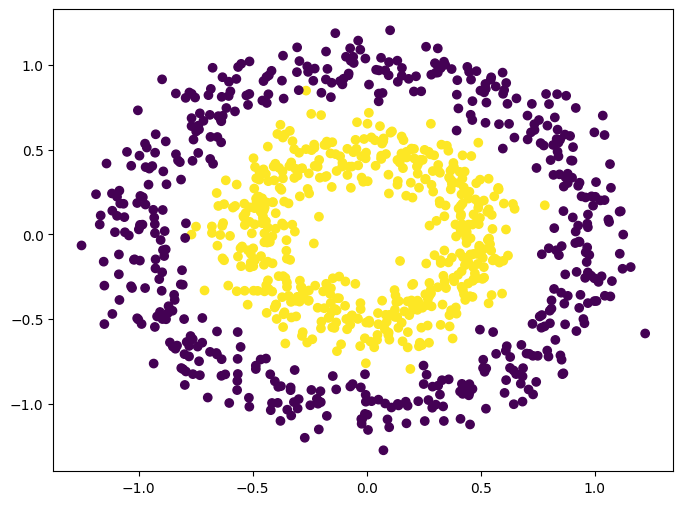

In [3]:
# Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt
import wandb

# Make data: Two circles on x-y plane as a classification problem
X, y = make_circles(n_samples=1000, factor=0.5, noise=0.1)
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

# Plot the data
plt.figure(figsize=(8,6))
plt.scatter(X[:,0], X[:,1], c=y)
plt.show()

# Define the model: A three-layer MLP with sigmoid activation
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.sigmoid(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

# Create the model
model = MLP(input_size=2, hidden_size=5, output_size=1)


In [4]:
# Initialize W&B
wandb.init(project="gradient-visualization", config={
    "epochs": 100,
    "batch_size": 32,
    "learning_rate": 0.1,
    "hidden_size": 5
})

# Get the config
config = wandb.config

# Define the loss function and the optimizer
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=config.learning_rate)

# Watch the model and log the gradients
wandb.watch(model, log="all")

# Train the model
for epoch in range(config.epochs):
    # Shuffle the data
    perm = torch.randperm(X.size(0))
    X = X[perm]
    y = y[perm]

    # Loop over batches
    for i in range(0, X.size(0), config.batch_size):
        # Get the batch
        X_batch = X[i:i+config.batch_size]
        y_batch = y[i:i+config.batch_size]

        # Forward pass
        y_pred = model(X_batch)

        # Compute the loss
        loss = criterion(y_pred, y_batch)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Log the loss and the accuracy
        with torch.no_grad():
            acc = ((y_pred > 0.5) == y_batch).float().mean()
            wandb.log({"loss": loss.item(), "acc": acc.item()})


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
